In [157]:
!python3 --version
import random
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece as spm
import datetime
import numpy as np
from datasets import load_dataset

# dataset = load_dataset("roneneldan/TinyStories")

# Generate the same random numbers
torch.manual_seed(42)

Python 3.7.3


/Library/Python/3.7/site-packages/urllib3/__init__.py:38: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  exceptions.NotOpenSSLWarning,
/Users/mimireyburn/Library/Python/3.7/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 361.94it/s]


Dataset parquet downloaded and prepared to /Users/mimireyburn/.cache/huggingface/datasets/roneneldan___parquet/roneneldan--TinyStories-455c9aeedc4b81cf/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


In [95]:
input_file = 'names.txt'
prefix = 'm'
vocab_size = 500

spm.SentencePieceTrainer.train(
    input=input_file, 
    model_prefix=prefix, 
    vocab_size=vocab_size
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: names.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 500
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differe

In [96]:
class Tokenizer:
    def __init__(self):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(f'{prefix}.model')
        self.vocab_size = self.sp.get_piece_size()

    def encode(self, name):
        return self.sp.encode_as_ids(name)

    def decode(self, tokens):
        return self.sp.decode_ids(tokens)
    
tokenizer = Tokenizer()

# for i in range(10):
#     print(tokenizer.decode([i]))

tokenizer.decode([0])


' ⁇ '

In [97]:

class Dataset(torch.utils.data.Dataset):
  def __init__(self):
    with open('names.txt', 'r') as f:
      self.names = f.read().split('\n')
    self.tokenizer = Tokenizer()

  def __len__(self):
    # Return number of names
    return len(self.names)

  def __getitem__(self, idx):
    # Get name at index
    name = self.names[idx]
    # Return encoded name
    return torch.tensor(self.tokenizer.encode(name))


ds = Dataset()
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)

BESFORMER

In [98]:

class BesSimpleTransformer(torch.nn.Module):
  def __init__(self):
    super(BesSimpleTransformer, self).__init__()
    # Embedding part of the model - 7 is the embedding size
    self.embedding    = torch.nn.Embedding(tokenizer.vocab_size, 7)
    self.pos_emb      = self.get_pos_matrix()
    # Mask tensor trick - if batch size is one, we might not need it - research it!
    self.register_buffer('mask', torch.tril(torch.ones(19, 19)))
    # First decoder block
    # 11 could be anything, if we have heads or batch_size this might change
    self.layer_00_key = torch.nn.Linear(7, 11)
    self.layer_00_qry = torch.nn.Linear(7, 11)
    self.layer_00_val = torch.nn.Linear(7, 11)
    self.layer_00_ffw = torch.nn.Linear(11, 7)
    # Second decoder block
    self.layer_01_key = torch.nn.Linear(7, 11)
    self.layer_01_qry = torch.nn.Linear(7, 11)
    self.layer_01_val = torch.nn.Linear(7, 11)
    self.layer_01_ffw = torch.nn.Linear(11, 7)
    # Output of the model
    self.map_to_vocab = torch.nn.Linear(7, tokenizer.vocab_size)

  def forward(self, x):
    emb = self.embedding(x)
    pos = self.pos_emb[0:x.shape[0], :]
    emb = emb + pos
    # emb.shape = (19, 7)


    key = self.layer_00_key(emb)
    qry = self.layer_00_qry(emb)
    val = self.layer_00_val(emb)
    att = torch.mm(qry, key.t())

    # mask from 0 to token end (square mask)
    msk = self.mask[0:x.shape[0], 0:x.shape[0]]
    # mask over tensor (same as adding it)
    att = att.masked_fill(msk == 0, float('-inf'))
    att_00 = torch.nn.functional.softmax(att, dim=1)
    att = torch.nn.functional.softmax(att, dim=1)
    res = torch.mm(att, val)
    # this is the feed forward layer
    res = self.layer_00_ffw(res)

    # do it all again with new q, k, v
    key = self.layer_01_key(res)
    qry = self.layer_01_qry(res)
    val = self.layer_01_val(res)
    att = torch.mm(qry, key.t())
    msk = self.mask[0:x.shape[0], 0:x.shape[0]]
    att = att.masked_fill(msk == 0, float('-inf'))
    att_01 = torch.nn.functional.softmax(att, dim=1)
    att = torch.nn.functional.softmax(att, dim=1)
    res = torch.mm(att, val)
    res = self.layer_01_ffw(res)

    # map back to our 29 vocab (alphabet + pos, eos, sos)
    out = self.map_to_vocab(res)
    return out, [att_00, att_01]

  def get_pos_matrix(self):
    store = torch.zeros(19, 7)
    for pos in range(19):
      # why do we do this range thing here?
      for i in range(0, 7, 2):
        denominator = 10000 ** (2 * i / 7)
        store[pos, i] = math.sin(pos / denominator)
        if i + 1 < 7: store[pos, i + 1] = math.cos(pos / denominator)
    return store


m = BesSimpleTransformer()

# SDG instead of Adam, why?
opt = torch.optim.Adam(m.parameters(), lr=0.01)

In [104]:
loss_history = []
num_epochs = 3
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{timestamp}_mimiformer.pth"
for epoch in range(num_epochs):
  for idx, batch in enumerate(dl):

    # sos = torch.tensor([2])
    # eos = torch.tensor([1])
    # Derive sos and eos from tokenizer
    sos = torch.tensor([tokenizer.sp.piece_to_id('<s>')])
    eos = torch.tensor([tokenizer.sp.piece_to_id('</s>')])


    # for each row in batch
    x = batch[0]
    # add sos to beginning of row
    x = torch.cat([sos, x])
    # In target tensor, add eos to end of each row and remove sos from start
    y = torch.cat([x[1:], eos])

    # run our batch through the whole transformer (attention1, ffw, attention2, ffw, linear)
    p, _ = m(x)
    # calculate cross-entropy loss between predicted token and target token
    l = torch.nn.functional.cross_entropy(p, y)
    # print loss every 1000 rows of dataset
    if idx % 1000 == 0: 
      loss_history.append(l.item())
      print("Loss:", l.item())
    # backpropogate for every row
    l.backward()
    # What is the optimiser doing?  Why is it called after we have done backward pass?
    opt.step()
    opt.zero_grad()
  # save model after each epoch
  timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  torch.save(m.state_dict(), save_path)
  
  

Loss: 9.733345031738281
Loss: 4.059566974639893
Loss: 3.6347904205322266
Loss: 3.3467376232147217
Loss: 3.767695188522339
Loss: 4.889268398284912
Loss: 2.9722506999969482
Loss: 2.8923511505126953
Loss: 3.966378688812256
Loss: 3.4461750984191895
Loss: 3.624953031539917
Loss: 3.410292863845825
Loss: 2.5276858806610107
Loss: 3.9807891845703125
Loss: 3.9593148231506348
Loss: 4.573742389678955
Loss: 4.0058369636535645
Loss: 4.242450714111328
Loss: 4.23654317855835
Loss: 4.34112548828125
Loss: 4.3220534324646
Loss: 3.5097618103027344
Loss: 3.3297271728515625
Loss: 5.180853366851807
Loss: 3.3380467891693115
Loss: 4.8098835945129395
Loss: 3.1031830310821533
Loss: 3.011960983276367
Loss: 2.959869146347046
Loss: 3.3655948638916016
Loss: 3.543698787689209
Loss: 4.422214508056641
Loss: 5.275639533996582
Loss: 11.697813034057617
Loss: 4.280121326446533
Loss: 3.711639404296875
Loss: 3.032632827758789
Loss: 4.161040782928467
Loss: 4.396218299865723
Loss: 3.165587902069092
Loss: 3.23061466217041
Loss:

100


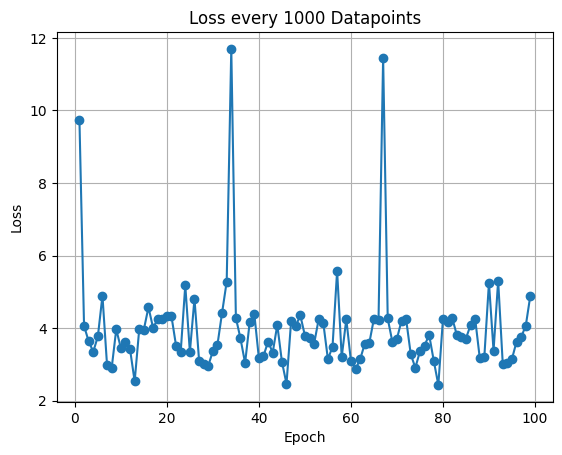

In [108]:
xaxis = len(loss_history) + 1
print(xaxis)
plt.plot(range(1, xaxis), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss every 1000 Datapoints')
plt.grid(True)
plt.show()

In [154]:

tokens = []
# generate a random start token for testing
# Get all the tokens/pieces from SentencePiece
all_tokens = [tokenizer.sp.id_to_piece(i) for i in range(tokenizer.vocab_size)]

# Pick a random token/piece
random_token = random.choice(all_tokens)

# Convert the token to its corresponding ID
x = torch.tensor([tokenizer.sp.piece_to_id(random_token)])
print(tokenizer.decode(x.tolist()))

sos = torch.tensor([tokenizer.sp.piece_to_id('<s>')])
x = torch.cat([sos, x])

top_p_threshold = 0.5

while True:
  tokens.append(x[-1].tolist())
  print("token", tokens)
  # run our random start through transformer and get attention matricies out
  p, attention = m(x)
  # create probabilities from 29 token options
  p = torch.nn.functional.softmax(p, dim=1)
  probs = p[-1].tolist()
  # choose the best prediction (most probable next token according to tranformer)
  p = torch.argmax(p, dim=1)

  #choose from the top 5 most probable tokens
  # sorted_probs = sorted(probs, reverse=True)
  # top_p = 0
  # for i in range(len(sorted_probs)):
  #   top_p += sorted_probs[i]
  #   if top_p > top_p_threshold:
  #     break
  # top_p = sorted_probs[:i+1]
  # top_p = torch.tensor(top_p)
  # p = torch.multinomial(top_p, 1)
  # p = torch.multinomial(p, 1)

  # unsqueeze to get the right dimensions for torch.cat
  # dimensions of x = [1, 1] and dimensions of p = [1]
  x = torch.cat([x, p[-1].unsqueeze(0)])
  if p[-1] == 1 or len(p.tolist()) == 17: break
print("Generate:", tokenizer.decode(x.tolist()))

est
token [328]
token [328, 288]
token [328, 288, 2]
token [328, 288, 2, 2]
token [328, 288, 2, 2, 2]
token [328, 288, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
token [328, 288, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Generate: est zi


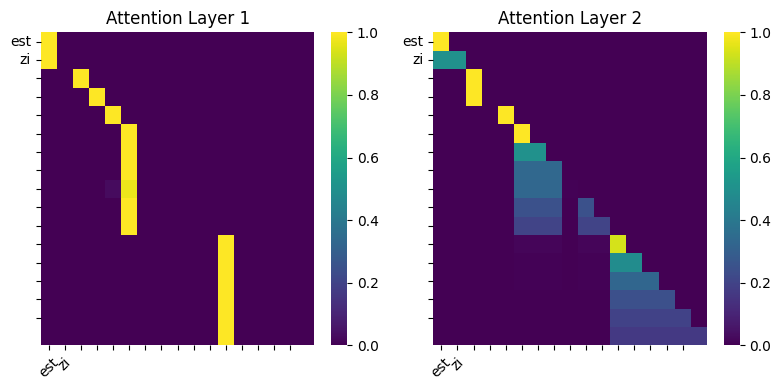

torch.Size([17, 17])


In [155]:

def plot_attention_heatmap(attention, tokens):
    decoded_tokens = [tokenizer.decode([tok]) for tok in tokens]
    num_layers = len(attention)
    fig, axes = plt.subplots(1, num_layers, figsize=(4*num_layers, 4))

    for idx, att in enumerate(attention):
        sns.heatmap(att.detach().numpy(), annot=False, cmap='viridis', ax=axes[idx], xticklabels=decoded_tokens, yticklabels=decoded_tokens)
        axes[idx].set_title(f'Attention Layer {idx + 1}')
        axes[idx].set_xticks(np.arange(len(decoded_tokens))+.5, minor=False)
        axes[idx].set_yticks(np.arange(len(decoded_tokens))+.5, minor=False)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()


# Assuming that you've tokenized 'x' and the tokens are stored in a variable called 'tokens'
plot_attention_heatmap(attention, tokens)

print(attention[0].shape)